In [1]:
from solver import Solver
from model import Net, NetConnected, NetConnected100
from model_nomatrix import NetNomatrix
from model_nomatrix3 import NetNomatrix16
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from experiment import get_data_loader
from lossfn import *

In [2]:
def get_train_range(dim):
    if dim == 2:
        train_range = range(1, 51, 1)
    elif dim == 3:
        train_range = range(10, 501, 10)
    elif dim == 5:
        train_range = range(50, 5001, 50)
    elif dim == 10:
        train_range = list(range(2500, 10000, 2500)) + list(range(10000, 30000, 5000)) + list(range(30000, 500001, 10000))
    return train_range

In [3]:
def get_checkpoint_dir(dim, ntrain, lossfn, seed=1683):
    return 'checkpoints/checkpoints_lossfn/checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, ntrain, lossfn, seed)
def get_checkpoint_dir2(dim, ntrain, lossfn, seed=1683):
    return 'checkpoints/checkpoints_lossfn2/checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, ntrain, lossfn, seed)

In [4]:
loss_fns = ['error', 'det', 'norm', 'detnorm']

In [5]:
def fn_pred_normed(pred):
    norms = torch.norm(pred.data, 2, 1)
    pred_normed = pred / norms.view(norms.shape[0], 1)
    return pred_normed

In [32]:
def plot_train_loss(dim, paths, logscale=True, labels=[], includeTest=False, model_class=Net, legendTitle=None, filename=None):
    fig = plt.figure(figsize=(13,7))
    if len(labels) == 0:
        labels = [''] * len(paths)
    for path, label in zip(paths, labels):
        # Plot train loss
        model = model_class(dim)
        solver = Solver(model)
        solver.load_checkpoint(path)
        for key in solver.hist["individual_train_losses"]:
            plt.plot(solver.hist["iterations"][1:], solver.hist["individual_train_losses"][key][1:], label=label+' '+("MSE" if key == "mse" else ("Norm loss" if key == "norm" else key.capitalize())))
        if includeTest:
            plt.plot(solver.hist["iterations"][1:], solver.hist["test_loss"][1:], label=label+' Test MSE')
    if legendTitle is not None:
        plt.legend(loc='best', title=legendTitle)
    else:
        plt.legend(loc='best')
    if logscale:
        plt.yscale('log')
    plt.ylabel("Loss value")
    plt.xlabel("Iteration")
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".svg", format="svg")
        plt.close()

In [13]:
def plot_test_loss(dim, train_range, keys, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False, legendTitle=None, filename=None):
    fig = plt.figure(figsize=(13,7))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
            solver = Solver(model)
            filepath = get_path(key, n_train)
            if os.path.exists(filepath):
                ntrains.append(n_train)
                solver.load_checkpoint(filepath)
                test_loss.append(solver.hist["test_loss"][-1])
                if includeNormed:
                    solver.fn_pred = fn_pred_normed
                    test_loss_normed.append(solver.test(test_loader, prints=False))
        plt.plot(ntrains, test_loss, label=key)
        if includeNormed:
            plt.plot(ntrains, test_loss_normed, label=str(key)+'_testnormed')
    if legendTitle is not None:
        plt.legend(loc='best', title=legendTitle)
    else:
        plt.legend(loc='best')
    if logscale:
        plt.yscale('log')
    plt.ylabel("Test MSE loss")
    plt.xlabel("Number of training data points")
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".svg", format="svg")
        plt.close()

In [120]:
def plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False, percentiles=True, max_iteration=float("inf"), model_class=lambda key: Net, legendTitle=None, filename=None, label=lambda key: key):
    fig = plt.figure(figsize=(13,7))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            test_loss_n_train = []
            test_loss_normed_n_train = []
            ntrains.append(n_train)
            for stat_val in stat_range:
                model = model_class(key)(dim)
                solver = Solver(model)
                filepath = get_path(key, n_train, stat_val)
                if os.path.exists(filepath):
                    solver.load_checkpoint(filepath)
                    test_index = len(solver.hist["test_loss"]) - 1
                    while (solver.hist["iterations"][test_index] > max_iteration):
                        test_index -= 1
                    test_loss_n_train.append(solver.hist["test_loss"][test_index])
                    if includeNormed:
                        solver.fn_pred = fn_pred_normed
                        test_loss_normed_n_train.append(solver.test(test_loader, prints=False))
                else:
                    print('Missing filepath:')
                    print(filepath)
            test_loss.append(test_loss_n_train)
            test_loss_normed.append(test_loss_normed_n_train)
        test_loss = np.array(test_loss)
        test_loss_normed = np.array(test_loss_normed)
        if len(test_loss):
            if percentiles:
                p = plt.plot(ntrains, np.median(test_loss, axis=1), label=label(key))
                color = p[0].get_color()
                plt.plot(ntrains, np.percentile(test_loss, 80, axis=1), linestyle='--', color=color, linewidth=0.5)
                plt.plot(ntrains, np.percentile(test_loss, 20, axis=1), linestyle='--', color=color, linewidth=0.5)
            else: 
                plt.errorbar(ntrains, test_loss.mean(axis=1), yerr=test_loss.std(axis=1), capsize=5, markeredgewidth=2, label=label(key))
        if includeNormed:
            plt.errorbar(ntrains, test_loss_normed.mean(axis=1), yerr=test_loss_normed.std(axis=1), capsize=5, markeredgewidth=2, label=str(key)+'_testnormed')
    if legendTitle is not None:
        plt.legend(loc='best', title=legendTitle)
    else:
        plt.legend(loc='best')
    plt.xlabel("Number of training data points")
    plt.ylabel("Test MSE loss")
    if logscale:
        plt.yscale('log')
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".svg", format="svg")
        plt.close()

In [9]:
def get_angles_norms_dets(test_loader, train_loader, solver):
    all_angles = []
    all_norms = []
    all_dets = []
    all_l2 = []
    for loader in [test_loader, train_loader]:
        for (points, angles, points_rotated) in loader:
            output_matrix, prediction = solver.forward(angles, points)
            all_angles += [x.item() for x in angles]
            all_norms += list(torch.norm(prediction, 2, 1).data.numpy())
            if output_matrix is not None:
                all_dets += [torch.det(mat).item() for mat in output_matrix]
            else:
                all_dets += [0 for _ in prediction]
            all_l2 += list(torch.sum(torch.nn.functional.mse_loss(prediction, points_rotated, reduction='none'), dim=1).detach().numpy())
    angles_norms = list(zip(all_angles, all_norms, all_dets, all_l2))
    angles_norms_sorted = list(zip(*sorted(angles_norms)))
    return angles_norms_sorted

In [10]:
def get_angles_stats_buckets(test_loader, train_loader, solver, n_buckets=50):
    angles_stats = get_angles_norms_dets(test_loader, train_loader, solver)
    angles_stats = [list(l) for l in zip(*angles_stats)]
    angle_min, angle_max = -math.pi, math.pi
    linspace = np.linspace(angle_min, angle_max, n_buckets+1)
    angles = [(linspace[i] + linspace[i+1])/2 for i in range(n_buckets)]
    buckets = [[] for _ in angles]
    linspace_i = 0
    for stats in angles_stats:
        angle = stats[0]
        while angle > linspace[linspace_i + 1]:
            linspace_i += 1
        buckets[linspace_i].append(stats)
    return angles, [list(zip(*b)) for b in buckets]

# Find best learning rate

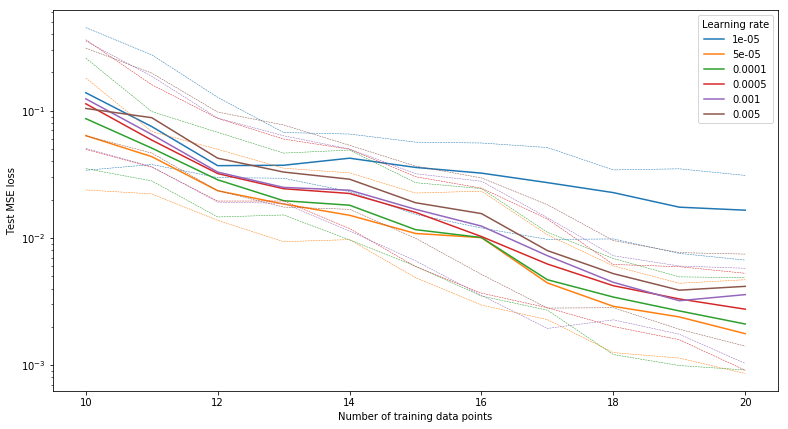

In [33]:
dim = 2
train_range = range(10, 21, 1)
keys = [1e-5, 5*1e-5, 1e-4, 5*1e-4, 1e-3, 5*1e-3]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, max_iteration=50000, legendTitle="Learning rate", filename="lr")

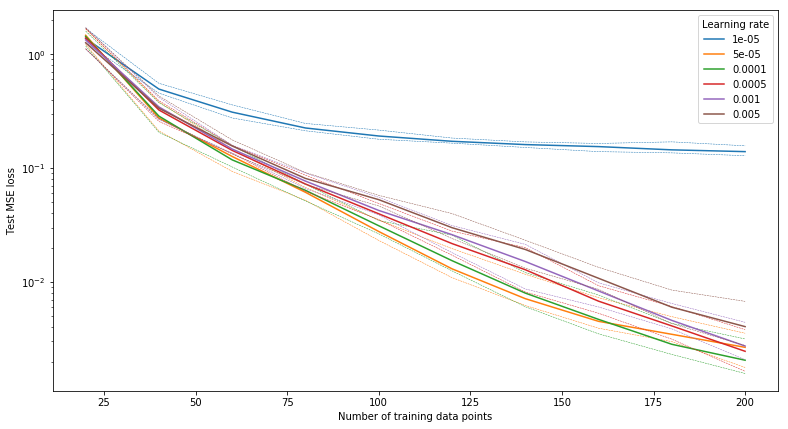

In [34]:
dim = 3
train_range = range(20, 201, 20)
keys = [1e-5, 5*1e-5, 1e-4, 5*1e-4, 1e-3, 5*1e-3]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, legendTitle="Learning rate", filename="lr3")

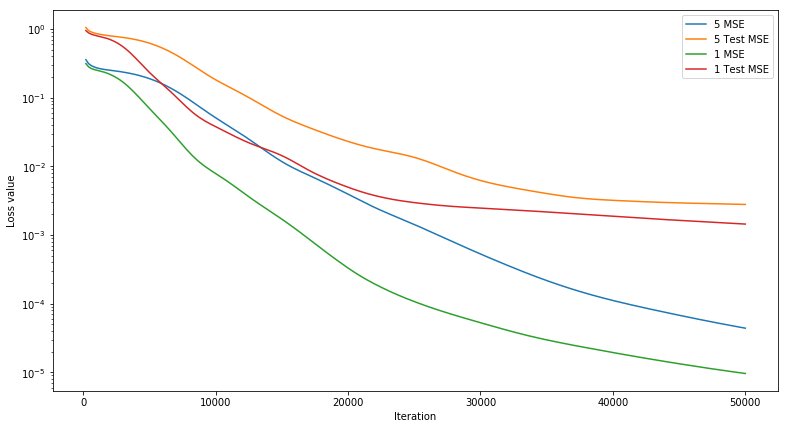

In [35]:
dim = 3
train_seed = 1690
n_train = 200#140
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_train_loss(dim, [get_path(5*1e-5, n_train, train_seed), get_path(1e-4, n_train, train_seed)], labels=["5", "1"], includeTest=True)


## Determinant weight

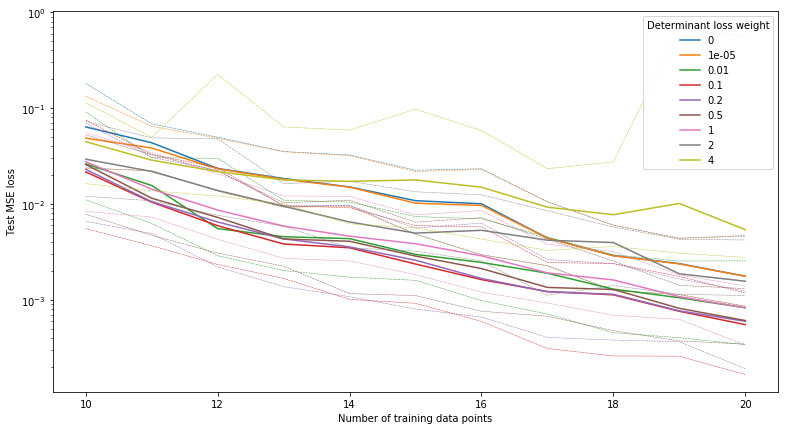

In [36]:
dim = 2
train_range = range(10, 21, 1)
keys = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight3/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, legendTitle="Determinant loss weight", filename="pnlty_det")

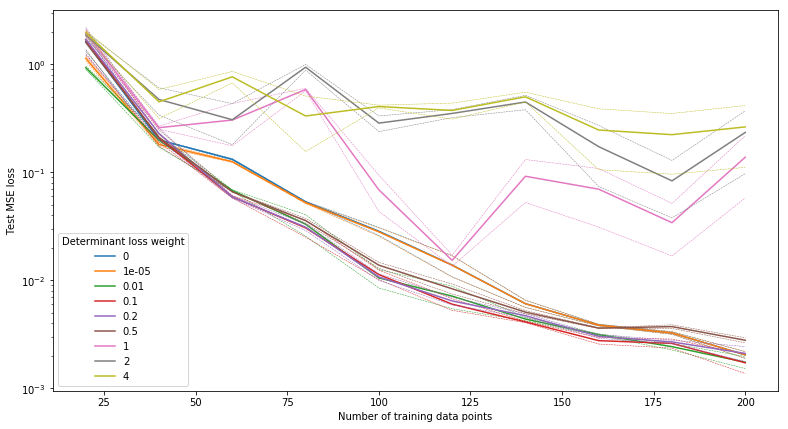

In [37]:
dim = 3
train_range = range(20, 201, 20)
keys = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
n_runs = 2
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight4/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, legendTitle="Determinant loss weight", filename="pnlty_det3")

0.019630681723356247
0.005100299138575792


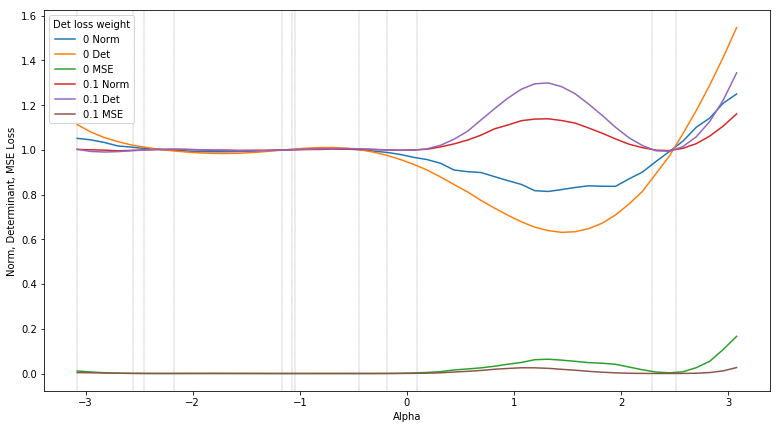

In [38]:
dim = 2
n_train = 12
train_seed = 1683
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
test_loader = get_data_loader(dim, 4096, seed=0, shuffle=False, batch_size=512)
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
# solver.fn_pred = fn_pred_normed

fig = plt.figure(figsize=(13,7))
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
for det_weight in [0, 0.1]:
    path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, det_weight, n_train, train_seed)
    solver.load_checkpoint(path)
    print(solver.hist["test_loss"][-1])
    angles, buckets = get_angles_stats_buckets(test_loader, train_loader, solver)
    #plt.plot(angles, [abs(1 - np.array(b[1]).mean()) for b in buckets], label=str(det_weight)+' '+'Norm')
    #plt.plot(angles, [abs(1 - np.array(b[2]).mean()) for b in buckets], label=str(det_weight)+' '+'Det')
    plt.plot(angles, [(np.array(b[1]).mean()) for b in buckets], label=str(det_weight)+' '+'Norm')
    plt.plot(angles, [(np.array(b[2]).mean()) for b in buckets], label=str(det_weight)+' '+'Det')
    plt.plot(angles, [np.array(b[3]).mean() for b in buckets], label=str(det_weight)+' '+'MSE')
plt.ylabel("Norm, Determinant, MSE Loss")
plt.xlabel("Alpha")
# plt.yscale('log')
plt.legend(loc='best', title="Det loss weight")
fig.savefig("figs/pnlty_det_anglestat.svg", format="svg")
plt.show()

## Norm weights

In [39]:
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight3/'
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'

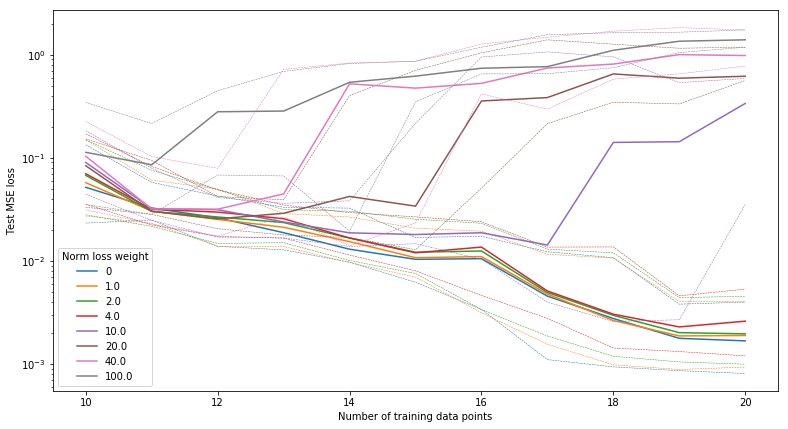

In [40]:
# add 1e-1 weight
dim = 2
train_range = range(10, 21, 1)
keys = [0, 1e0, 2e0, 4e0, 1e1, 2e1, 4e1, 1e2]
n_runs = 10
stat_range = range(1683, 1683 + n_runs, 1)
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="pnlty_norm", legendTitle="Norm loss weight")

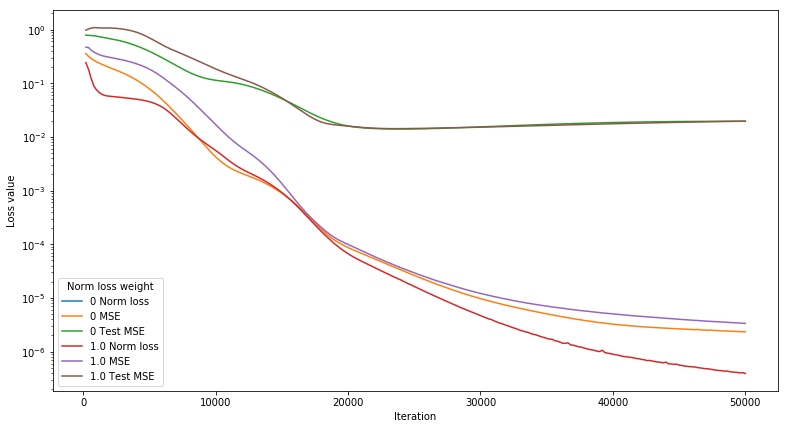

In [41]:
# change norm weight to 1e-1
dim = 2
n_train = 12
train_seed = 1683
norm_weight = 1e0
paths = [get_path(0, n_train, train_seed), get_path(norm_weight, n_train, train_seed)]
plot_train_loss(dim, paths, labels=['0', str(norm_weight)], includeTest=True, filename="pnlty_norm_train", legendTitle="Norm loss weight")

### 3 dimensions

In [42]:
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight3/'
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'

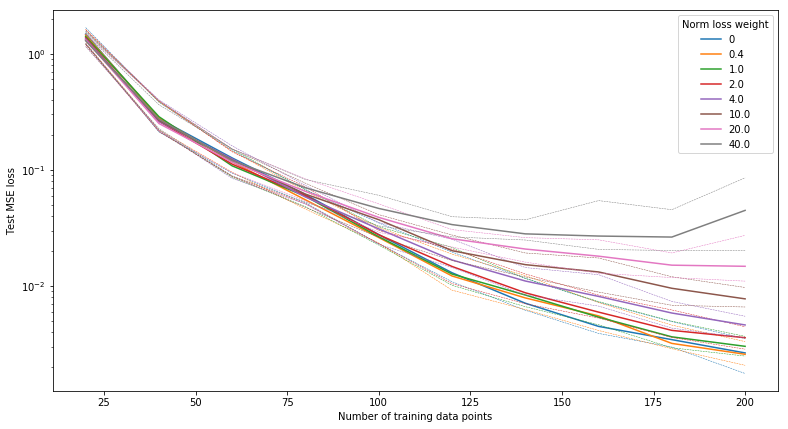

In [43]:
dim = 3
train_range = range(20, 201, 20)
keys = [0, 4e-1, 1e0, 2e0, 4e0, 1e1, 2e1, 4e1]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="pnlty_norm3", legendTitle="Norm loss weight")

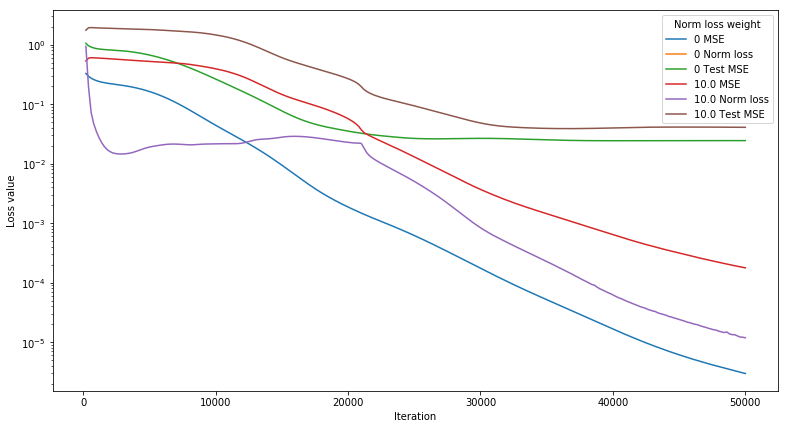

In [44]:
dim = 3
n_train = 100
train_seed = 1683
norm_weight = 1e1
paths = [get_path(0, n_train, train_seed), get_path(norm_weight, n_train, train_seed)]
plot_train_loss(dim, paths, labels=['0', str(norm_weight)], includeTest=True, filename="pnlty_norm_train3", legendTitle="Norm loss weight")

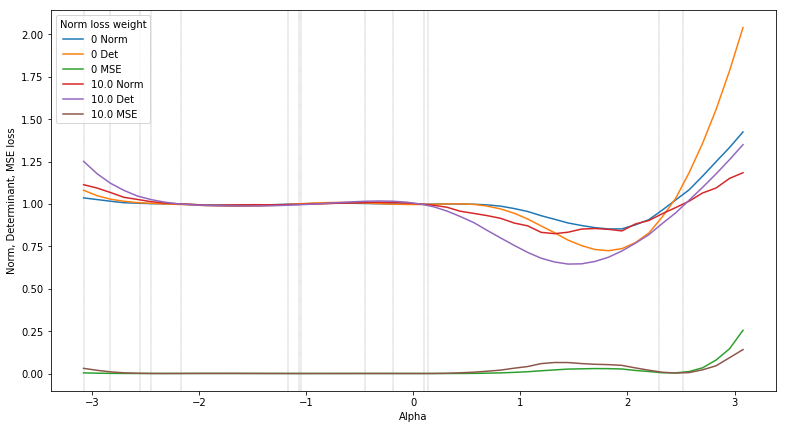

Train loss


In [45]:
dim = 2
n_train = 14
train_seed = 1683
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
test_loader = get_data_loader(dim, 4096, seed=0, shuffle=False, batch_size=512)
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
# solver.fn_pred = fn_pred_normed

fig = plt.figure(figsize=(13,7))
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
paths = []
labels = []
for norm_weight in [0, 1e1]:
    path = 'checkpoints/round2_normweight3/dim-{}_normweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, norm_weight, n_train, train_seed)
    paths.append(path)
    solver.load_checkpoint(path)
    angles, buckets = get_angles_stats_buckets(test_loader, train_loader, solver)
    #plt.plot(angles, [abs(1 - np.array(b[1]).mean()) for b in buckets], label=str(det_weight)+' '+'Norm')
    #plt.plot(angles, [abs(1 - np.array(b[2]).mean()) for b in buckets], label=str(det_weight)+' '+'Det')
    plt.plot(angles, [(np.array(b[1]).mean()) for b in buckets], label=str(norm_weight)+' '+'Norm')
    plt.plot(angles, [(np.array(b[2]).mean()) for b in buckets], label=str(norm_weight)+' '+'Det')
    plt.plot(angles, [np.array(b[3]).mean() for b in buckets], label=str(norm_weight)+' '+'MSE')
    labels.append(str(norm_weight))
plt.ylabel("Norm, Determinant, MSE loss")
plt.xlabel("Alpha")
# plt.yscale('log')
plt.legend(loc='best', title="Norm loss weight")
plt.show()
fig.savefig("figs/pnlty_norm_anglestat_ntrain{}.svg".format(n_train), format="svg")
print("Train loss")
# plot_train_loss(dim, paths, labels=labels, includeTest=True)

## Regularization weights

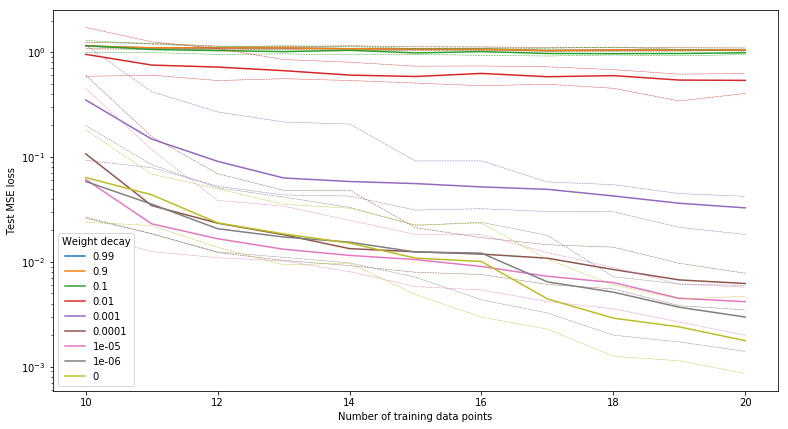

In [46]:
dim = 2
train_range = range(10, 21, 1)
keys = [0.99, 0.9, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_weight_decay2/'
    checkpoint_dir += 'dim-{}_ntrain-{}_weightdecay-{}_seed-{}/'.format(dim, n_train, key, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="weightdecay", legendTitle="Weight decay")

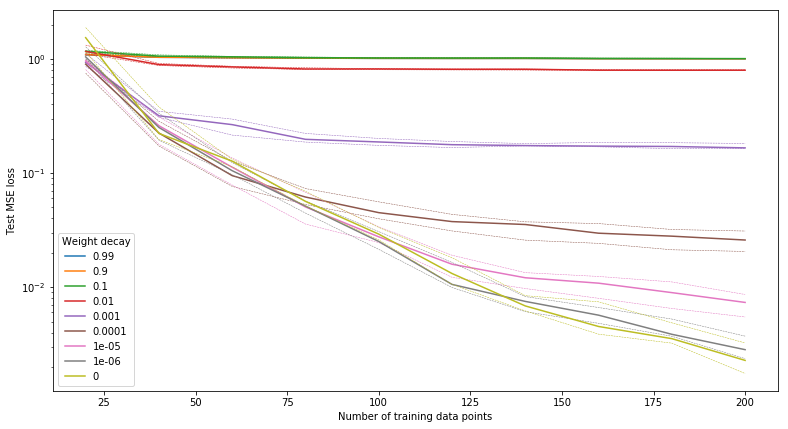

In [47]:
dim = 3
train_range = range(20, 201, 20)
keys = [0.99, 0.9, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0]
n_runs = 9
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_weight_decay2/'
    checkpoint_dir += 'dim-{}_ntrain-{}_weightdecay-{}_seed-{}/'.format(dim, n_train, key, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="weightdecay3", legendTitle="Weight decay")

## Best weights

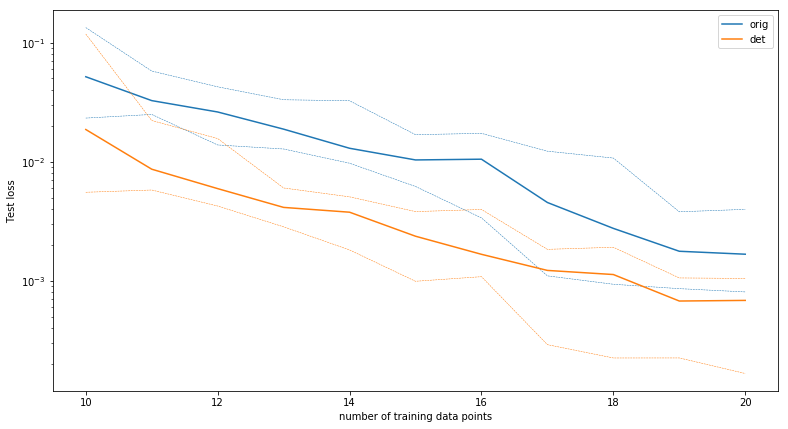

In [203]:
#return
dim = 2
train_range = range(10, 21, 1) if dim == 2 else range(20, 201, 20)
keys = ['orig', 'det']#['orig', 'det', 'norm', 'detnorm']
n_runs = 10
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    if key == 'orig':
        checkpoint_dir += 'round2_detweight3/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, 0, n_train, stat_val)
    elif key == 'det':
        checkpoint_dir += 'round2_detweight3/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, 0.1, n_train, stat_val)
    elif key == 'norm':
        checkpoint_dir += 'round2_normweight2/'
        checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, 0.01 if dim==2 else 0.1, n_train, stat_val)
    else:
        checkpoint_dir += 'round2_det_norm_loss/'
        checkpoint_dir += 'dim-{}_detweight-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, 0.1, 0.01 if dim==2 else 0.1, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

## Normed determinant

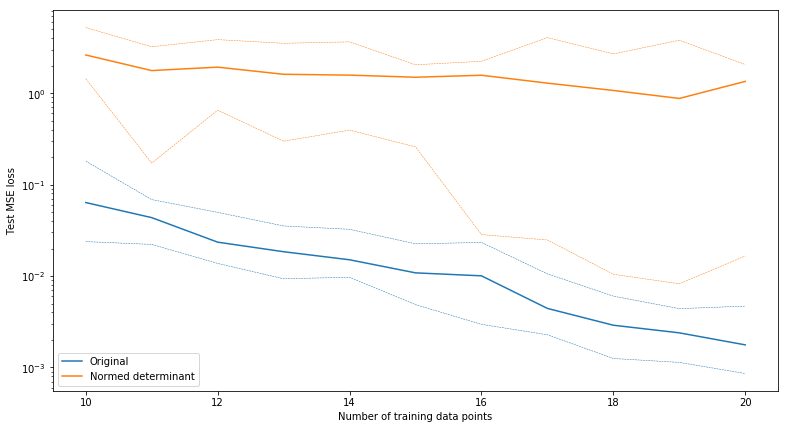

In [48]:
dim = 2
train_range = range(10, 21, 1)
keys = ["Original", "Normed determinant"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_det/'
    checkpoint_dir += 'dim-{}_normeddet-{}_ntrain-{}_seed-{}/'.format("orig" if key == "Original" else "normed", dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="normed_det")

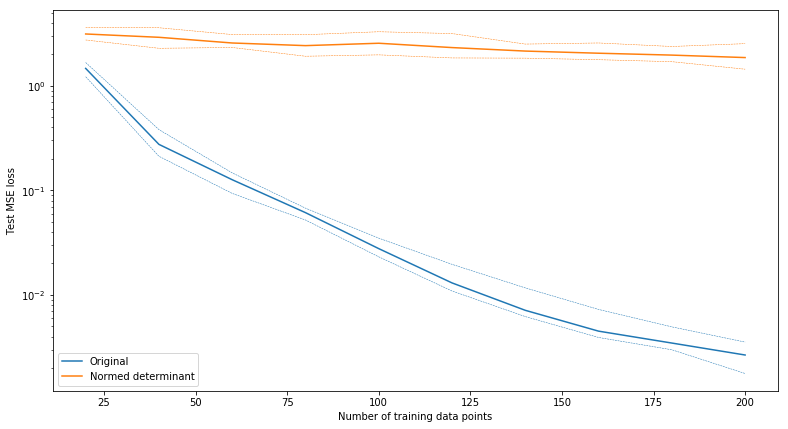

In [49]:
dim = 3
train_range = range(20, 201, 20)
keys = ["Original", "Normed determinant"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_det/'
    checkpoint_dir += 'dim-{}_normeddet-{}_ntrain-{}_seed-{}/'.format("orig" if key == "Original" else "normed", dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="normed_det3")

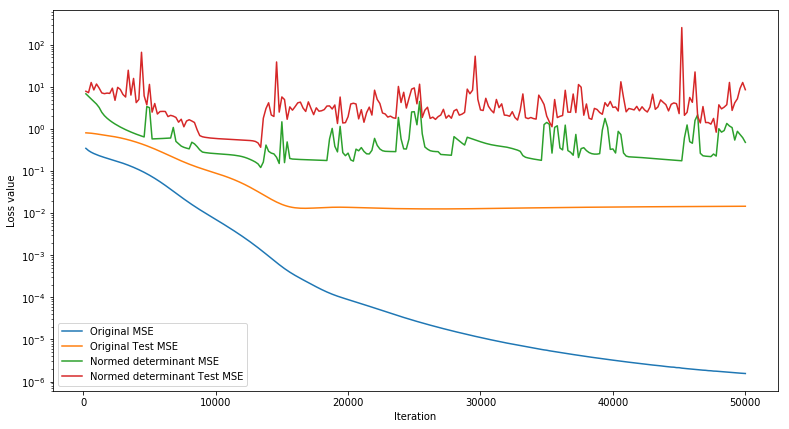

In [50]:
dim = 2
train_seed = 1683
n_train = 15
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_det/'
    checkpoint_dir += 'dim-{}_normeddet-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
paths = [get_path("orig", n_train, train_seed), get_path("normed", n_train, train_seed)]
plot_train_loss(dim, paths, labels=["Original", "Normed determinant"], includeTest=True, filename="normed_det_train_ntrain{}".format(n_train))


## Normed prediction

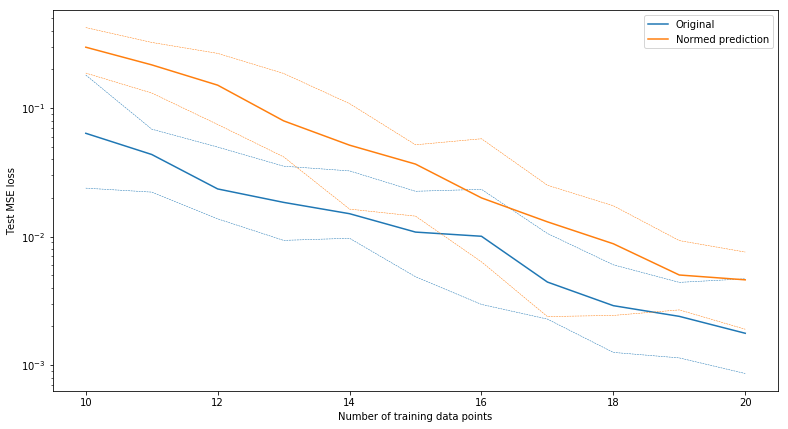

In [51]:
dim = 2
train_range = range(10, 21, 1)
keys = ["Original", "Normed prediction"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format("orig" if key == "Original" else "normed", dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="normed_pred")

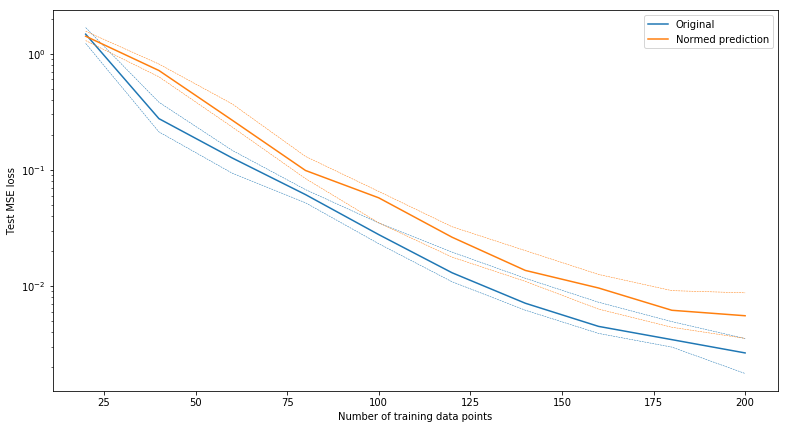

In [52]:
dim = 3
train_range = range(20, 201, 20)
keys = ["Original", "Normed prediction"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format("orig" if key == "Original" else "normed", dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="normed_pred3")

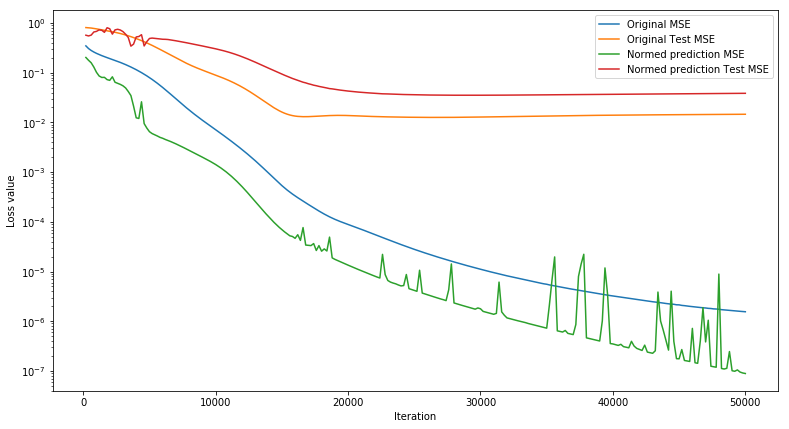

In [53]:
dim = 2
train_seed = 1683
n_train = 15
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
paths = [get_path("orig", n_train, train_seed), get_path("normed", n_train, train_seed)]
plot_train_loss(dim, paths, labels=["Original", "Normed prediction"], includeTest=True, filename="normed_pred_train_ntrain{}".format(n_train))


1.0146943655472125
0.0016517178910105943


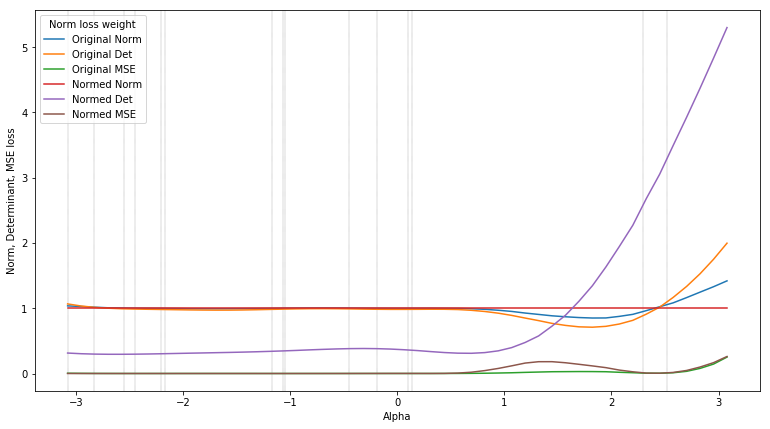

In [161]:
dim = 2
n_train = 15
train_seed = 1683
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
test_loader = get_data_loader(dim, 4096, seed=0, shuffle=False, batch_size=512)
model = Net(dim)
solver = Solver(model)

fig = plt.figure(figsize=(13,7))
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
paths = []
labels = []
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'

for key in ["orig", "normed"]:
    path = get_path(key, n_train, train_seed)
    paths.append(path)
    solver.load_checkpoint(path)
    if key == "normed":
        solver.fn_pred = fn_pred_normed
    angles, buckets = get_angles_stats_buckets(test_loader, train_loader, solver)
    #plt.plot(angles, [abs(1 - np.array(b[1]).mean()) for b in buckets], label=str(det_weight)+' '+'Norm')
    #plt.plot(angles, [abs(1 - np.array(b[2]).mean()) for b in buckets], label=str(det_weight)+' '+'Det')
    label = "Original" if key == "orig" else "Normed"
    plt.plot(angles, [(np.array(b[1]).mean()) for b in buckets], label=str(label)+' '+'Norm')
    det_mean = np.mean([np.array(b[2]).mean() for b in buckets])
    print(det_mean)
    plt.plot(angles, [np.array(b[2]).mean() / det_mean for b in buckets], label=str(label)+' '+'Det')
    plt.plot(angles, [np.array(b[3]).mean() for b in buckets], label=str(label)+' '+'MSE')
    labels.append(str(key))
plt.ylabel("Norm, Determinant, MSE loss")
plt.xlabel("Alpha")
# plt.yscale('log')
plt.legend(loc='best', title="Norm loss weight")
plt.show()
fig.savefig("figs/normed_anglestat_ntrain{}.svg".format(n_train), format="svg")


# Augmented lagrangian method

In [92]:
def plot_train_loss2(dim, paths, logscale=True, labels=[], includeTest=False, legendTitle=None, filename=None):
    fig = plt.figure(figsize=(13,7))
    if len(labels) == 0:
        labels = [''] * len(paths)
    for path, label in zip(paths, labels):
        # Plot train loss
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        solver.load_checkpoint(path)
        # for key in solver.hist["individual_train_losses"]:
        #     plt.plot(solver.hist["iterations"], solver.hist["individual_train_losses"][key], label=key+'_'+label)
        #if 'det' in solver.hist["individual_train_losses"]:
        #    plt.plot(solver.hist["iterations"], solver.hist["individual_train_losses"]['det'], label='det'+'_'+label)
        if includeTest:
            plt.plot(solver.hist["iterations"], solver.hist["test_loss"], label=label)
    if legendTitle is not None:
        plt.legend(loc='best', title=legendTitle)
    else:
        plt.legend(loc='best')
    if logscale:
        plt.yscale('log')
    plt.xlabel("Iteration")
    plt.ylabel("Test MSE loss")
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".svg", format="svg")
        plt.close()

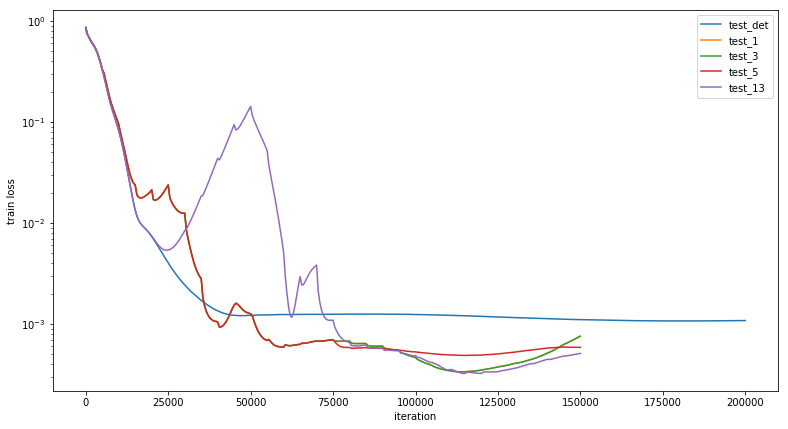

In [241]:
configs = [
    # 1
    {'weights': [1e-2] * 30,
     'iterations': [5000] * 30},
    # 3
    {'weights': [1e-2] * 30,
     'iterations': [5000] * 30},
    # 5
    {'weights': [1e-2] * 15 + [1e-1] * 15,
     'iterations': [5000] * 30},
    # 13
    {'weights': [1e-2] * 1 + [1.3**j * 1e-4 for j in range(26)],
     'iterations': [20000] + [5000] * 26},
]
paths = []
labels = []
dim = 2
n_train = 17
train_seed = 1683
det_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0.1, n_train, train_seed)
for i in [1, 3, 5, 13]:
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_aug_lag_rnd/'
    checkpoint_dir += 'dim-{}_config-{}_ntrain-{}_seed-{}/'.format(dim, i, n_train, train_seed)
    paths.append(checkpoint_dir + 'final.pkl')
    labels.append(str(i))
# print(paths)
plot_train_loss2(dim, ['tmp_det_many_iterations/final.pkl'] + paths, labels=['det'] + labels, includeTest=True)


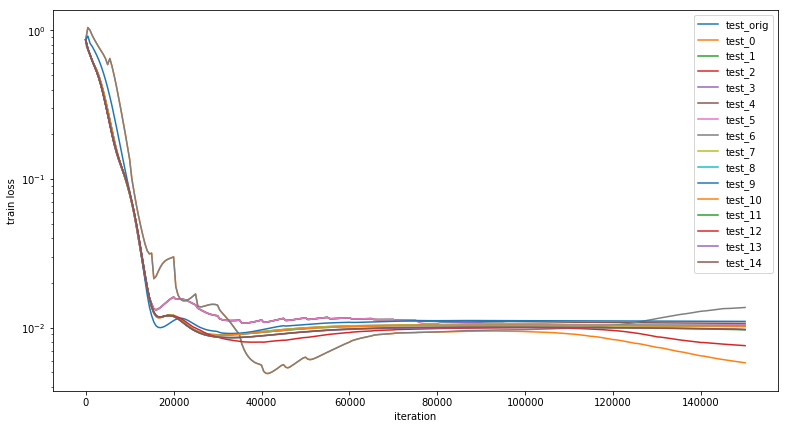

In [273]:
configs = [
    {'weights': [1e-1] * 30,
     'iterations': [5000] * 30},
    {'weights': [1e-2] * 30,
     'iterations': [5000] * 30},
    {'weights': [1e-3] * 30,
     'iterations': [5000] * 30},
    {'weights': [1e-2] * 30,
     'iterations': [5000] * 30},
    {'weights': [1e-2] * 15 + [1e-3] * 15,
     'iterations': [5000] * 30},
    {'weights': [1e-2] * 15 + [1e-1] * 15,
     'iterations': [5000] * 30},
    #6
    {'weights': [1e-1] * 15 + [1e-2] * 15,
     'iterations': [5000] * 30},
    {'weights': [1e-3] * 15 + [1e-2] * 15,
     'iterations': [5000] * 30},
    {'weights': [2**j * 1e-4 for j in range(10)],
     'iterations': [15000] * 10},
    {'weights': list(reversed([2**j * 1e-4 for j in range(10)])),
     'iterations': [15000] * 10},
    {'weights': [1.3**j * 1e-4 for j in range(30)],
     'iterations': [5000] * 30},
    {'weights': [1e-2] * 1 + [1e-3] * 26,
     'iterations': [20000] + [5000] * 26},
    {'weights': [1e-2] * 1 + [1e-1] * 26,
     'iterations': [20000] + [5000] * 26},
    {'weights': [1e-2] * 1 + [1.3**j * 1e-4 for j in range(26)],
     'iterations': [20000] + [5000] * 26},
    {'weights': [1e-2] * 1 + [1.3**j * 1e-3 for j in range(26)],
     'iterations': [20000] + [5000] * 26},
]
paths = []
labels = []
dim = 2
n_train = 17
train_seed = 1683
norm_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0, n_train, train_seed)
for i in range(len(configs)):#[6]:#
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_aug_lag_rnd_norm/'
    checkpoint_dir += 'dim-{}_config-{}_ntrain-{}_seed-{}/'.format(dim, i, n_train, train_seed)
    paths.append(checkpoint_dir + 'final.pkl')
    labels.append(str(i))

plot_train_loss2(dim, [norm_path]+paths, labels=['orig']+labels, includeTest=True)


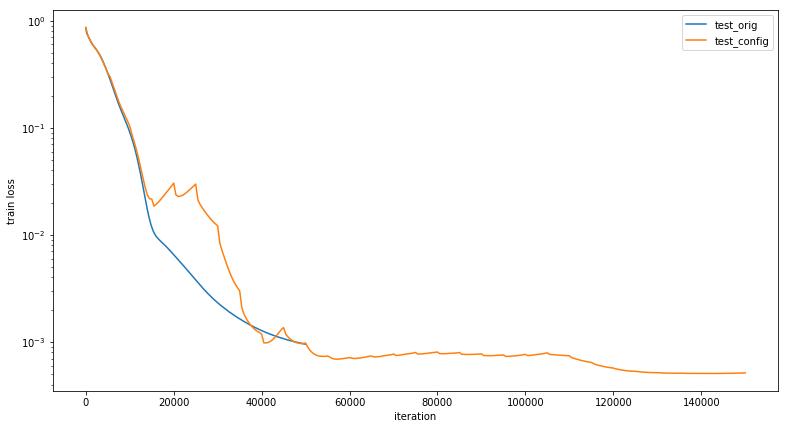

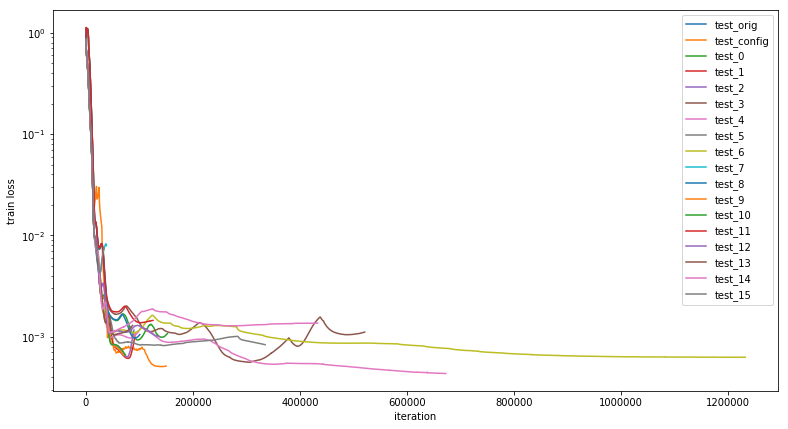

In [275]:
train_range = range(10, 21, 4)
n_runs = 2
dim = 2

configs = [
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.01,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1.02,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.05,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.0001,
     'constraint_sq_weight_multiplier': 1.1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.001,
     'constraint_sq_weight_multiplier': 1.1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 1e-5,
     'constraint_sq_weight_multiplier': 2,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 20},
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.01,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1.02,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.05,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.0001,
     'constraint_sq_weight_multiplier': 1.1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.001,
     'constraint_sq_weight_multiplier': 1.1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 1e-5,
     'constraint_sq_weight_multiplier': 2,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 20},
]
paths = []
labels = []
n_train = 18
train_seed = 1683
norm_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0.1, n_train, train_seed)
for i in range(len(configs)):#[6]:#
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_aug_lag_auto_det/'
    checkpoint_dir += 'dim-{}_config-{}_ntrain-{}_seed-{}/'.format(dim, i, n_train, train_seed)
    paths.append(checkpoint_dir + 'final.pkl')
    labels.append(str(i))

plot_train_loss2(dim, [norm_path, 'tmpx/final.pkl'], labels=['orig', 'config'], includeTest=True)
plot_train_loss2(dim, [norm_path, 'tmpx/final.pkl']+paths, labels=['orig', 'config']+labels, includeTest=True)


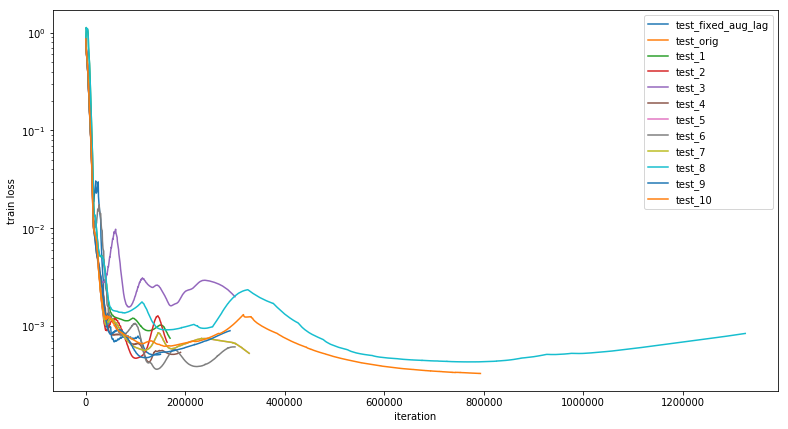

In [293]:
auto_configs = [
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1,
     'eps': 0,
     'gam': 0,
     'eps_gam_decay_rate': 0,
     'grad_threshold': 1e-3,
     'iterations': 50},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1,
     'eps': 0,
     'gam': 0,
     'eps_gam_decay_rate': 0,
     'grad_threshold': 1e-3,
     'iterations': 50},
    {'constraint_sq_weight': 0.0001,
     'constraint_sq_weight_multiplier': 1.05,
     'eps': 0,
     'gam': 0,
     'eps_gam_decay_rate': 0,
     'grad_threshold': 1,
     'iterations': 100},
    # chosen one
    {'constraint_sq_weight': 0.001,
     'constraint_sq_weight_multiplier': 1.05,
     'eps': 1e-3,
     'gam': 0.1,
     'eps_gam_decay_rate': 0.95,
     'grad_threshold': None,
     'iterations': 50},
    
        {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.05,
     'eps': 1e-3,
     'gam': 0.1,
     'eps_gam_decay_rate': 0.95,
     'grad_threshold': None,
     'iterations': 50},
    {'constraint_sq_weight': 0.001,
     'constraint_sq_weight_multiplier': 1.05,
     'eps': 0,
     'gam': 0,
     'eps_gam_decay_rate': 0,
     'grad_threshold': 1,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.05,
     'eps': 1e-3,
     'gam': 0.1,
     'eps_gam_decay_rate': 0.95,
     'grad_threshold': None,
     'iterations': 50},
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1.05,
     'eps': 1e-3,
     'gam': 0.1,
     'eps_gam_decay_rate': 0.95,
     'grad_threshold': None,
     'iterations': 50},
    {'constraint_sq_weight': 0.001,
     'constraint_sq_weight_multiplier': 1.1,
     'eps': 1e-3,
     'gam': 0.1,
     'eps_gam_decay_rate': 0.95,
     'grad_threshold': None,
     'iterations': 50},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.1,
     'eps': 1e-3,
     'gam': 0.1,
     'eps_gam_decay_rate': 0.95,
     'grad_threshold': None,
     'iterations': 50},

]
checkpoint_dir = lambda config: 'tmp_aug/sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'], config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
other_paths = ['checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0.1, n_train, train_seed),
               ]
paths = other_paths + []
for config in [] + auto_configs:
    paths.append(checkpoint_dir(config)+'final.pkl')
labels = [str(x) for x in range(len(paths))]
labels[0] = 'orig'
plot_train_loss2(dim, ['tmpx/final.pkl'] + paths, logscale=True, labels=['fixed_aug_lag'] + labels, includeTest=True)


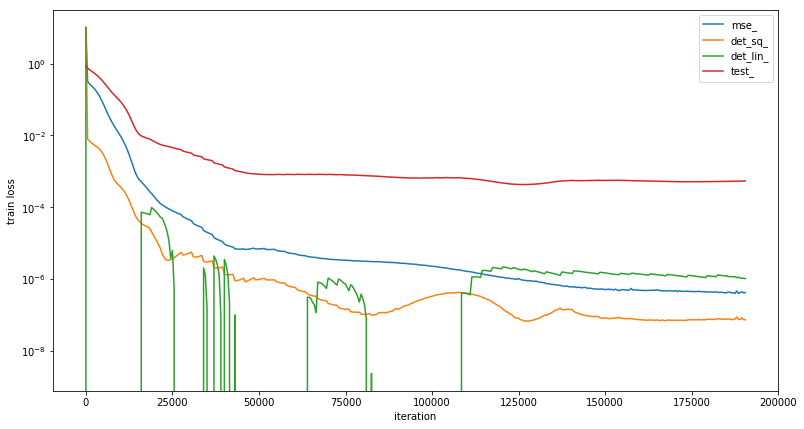

In [297]:
plot_train_loss(dim, ['tmp_aug/sqweight-0.001_sqwmul-1.05_eps-0.001_gam-0.1_decrate-0.95_gradthresh-None_it-50/final.pkl'], includeTest=True)

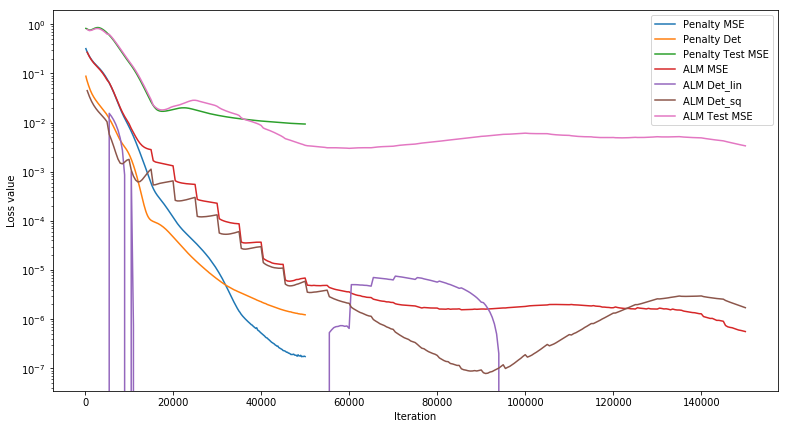

In [88]:
dim = 2
n_train = 12
train_seed = 1686
config = {'constraint_sq_weight': 0.001,
          'constraint_sq_weight_multiplier': 1.05,
          'eps': 1e-3,
          'gam': 0.1,
          'eps_gam_decay_rate': 0.95,
          'grad_threshold': None,
          'iterations': 50}
"""
checkpoint_dir = 'checkpoints/'
checkpoint_dir += 'round2_aug_lag_det/'
checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
    config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
    config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, train_seed)
"""
checkpoint_dir = 'checkpoints/'
checkpoint_dir += 'round2_aug_lag_det_fixed/'
checkpoint_dir += 'config_0/'
checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, train_seed)

orig_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0.1, n_train, train_seed)
plot_train_loss(dim, [orig_path, checkpoint_dir + 'final.pkl'], labels=["Penalty", "ALM"], includeTest=True)
#plot_train_loss(dim, [orig_path, checkpoint_dir + 'final.pkl'], labels=["Penalty", "ALM"], includeTest=True, filename="alm_fix_ntrain{}".format(n_train))

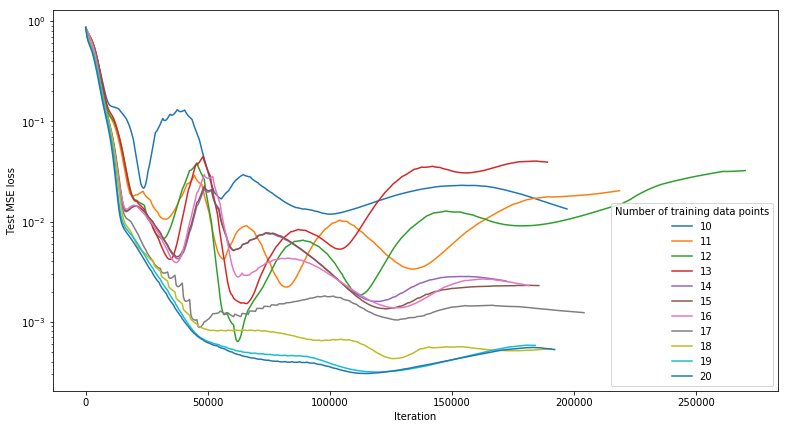

In [95]:
paths = []
labels = []
config = {'constraint_sq_weight': 0.001,
          'constraint_sq_weight_multiplier': 1.05,
          'eps': 1e-3,
          'gam': 0.1,
          'eps_gam_decay_rate': 0.95,
          'grad_threshold': None,
          'iterations': 50}
train_seed = 1683
norm_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0.1, n_train, train_seed)
for n_train in range(10,21,1):#[6]:#
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_aug_lag_det/'
    checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
        config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
        config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
    checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, train_seed)
    paths.append(checkpoint_dir + 'final.pkl')
    labels.append(str(n_train))

plot_train_loss2(dim, paths, labels=labels, includeTest=True, legendTitle="Number of training data points", filename="alm_dyn_test_train")


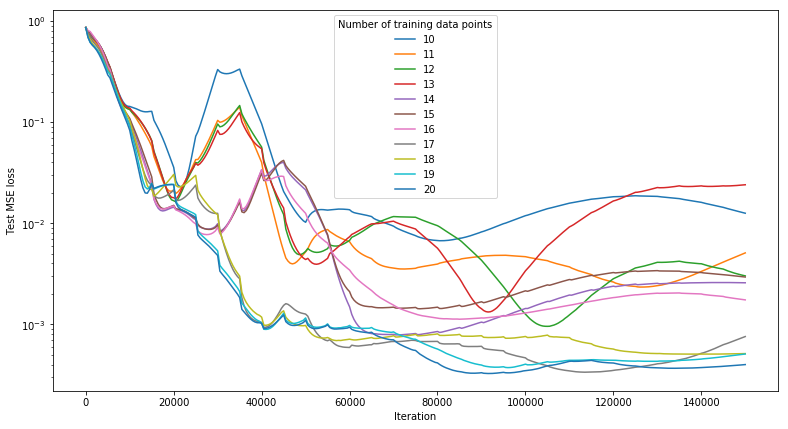

In [96]:
dim = 2
paths = []
labels = []
config = {'weights': [1e-2] * 30, 'iterations': [5000] * 30}
train_seed = 1683
norm_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0.1, n_train, train_seed)
for n_train in range(10,21,1):#[6]:#
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_aug_lag_det_fixed/'
    checkpoint_dir += 'config_0/'
    checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, train_seed)
    paths.append(checkpoint_dir + 'final.pkl')
    labels.append(str(n_train))

plot_train_loss2(dim, paths, labels=labels, includeTest=True, legendTitle="Number of training data points", filename="alm_fix_test_train")


In [97]:
def get_path(key, n_train, stat_val):
    if key == "ALM dynamic":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det/'
        checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
            config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
            config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "ALM dynamic (no linear)":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_nolin/'
        checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
            config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
            config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "ALM fixed":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_fixed/'
        checkpoint_dir += 'config_0/'
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "ALM fixed (no linear)":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_fixed_nolin/'
        checkpoint_dir += 'config_0/'
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "Penalty method":
        checkpoint_dir = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0.1, n_train, stat_val)
    else:
        checkpoint_dir = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'


In [100]:
dim = 2
train_range = range(10, 21, 1)
keys = ["Original", "Penalty method", "ALM dynamic", "ALM dynamic (no linear)", "ALM fixed", "ALM fixed (no linear)"]
n_runs = 6
stat_range = range(1683, 1683 + n_runs, 1)
config = {'weights': [1e-2] * 30, 'iterations': [5000] * 30}
config = {'constraint_sq_weight': 0.001,
          'constraint_sq_weight_multiplier': 1.05,
          'eps': 1e-3,
          'gam': 0.1,
          'eps_gam_decay_rate': 0.95,
          'grad_threshold': None,
          'iterations': 50}

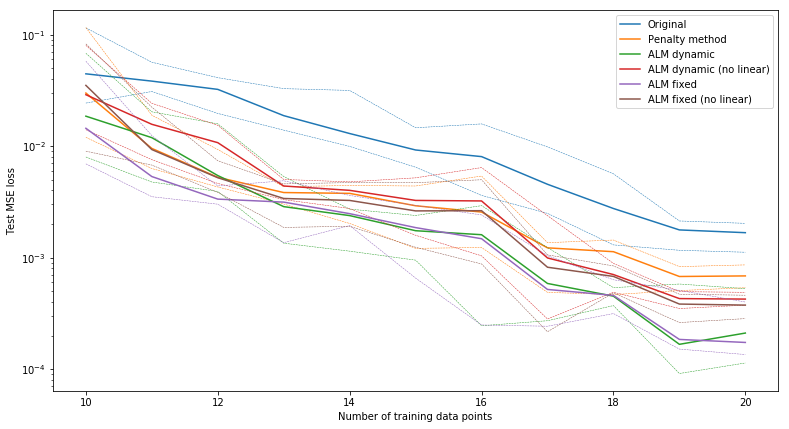

In [99]:
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="alm_comparison")

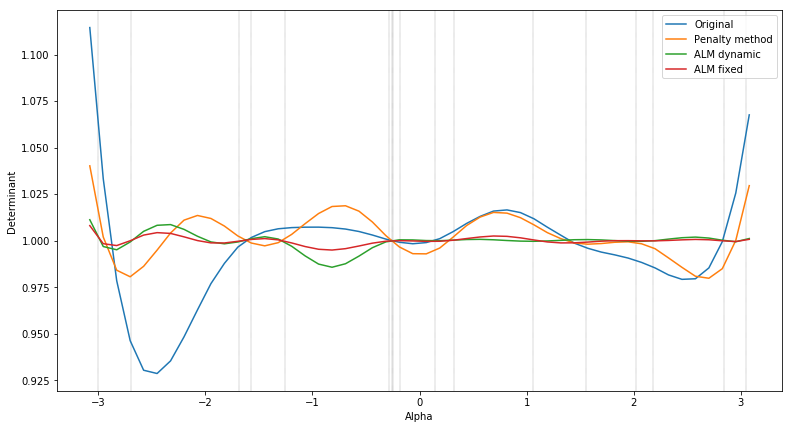

Train loss


In [112]:
dim = 2
#n_train = 17
#train_seed = 1685
n_train = 17
train_seed = 1685
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
test_loader = get_data_loader(dim, 4096, seed=0, shuffle=False, batch_size=512)
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
# solver.fn_pred = fn_pred_normed

fig = plt.figure(figsize=(13,7))
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
paths = []
labels = []
for key in ["Original", "Penalty method", "ALM dynamic", "ALM fixed"]:
    path = get_path(key, n_train, train_seed)
    paths.append(path)
    solver.load_checkpoint(path)
    angles, buckets = get_angles_stats_buckets(test_loader, train_loader, solver)
    # plt.plot(angles, [np.array(b[1]).mean() for b in buckets], label=str(key)+'_'+'norm')
    plt.plot(angles, [np.array(b[2]).mean() for b in buckets], label=str(key))
    # plt.plot(angles, [np.array(b[3]).mean() for b in buckets], label=str(key)+'_'+'l2')
    labels.append(str(key))
plt.ylabel("Determinant")
plt.xlabel("Alpha")
# plt.yscale('log')
plt.legend(loc='best')
plt.show()
fig.savefig("figs/alm_det_comparison_ntrain{}.svg".format(n_train), format="svg")
print("Train loss")
# plot_train_loss(dim, paths, labels=labels, includeTest=True)

## Aug lag on norm

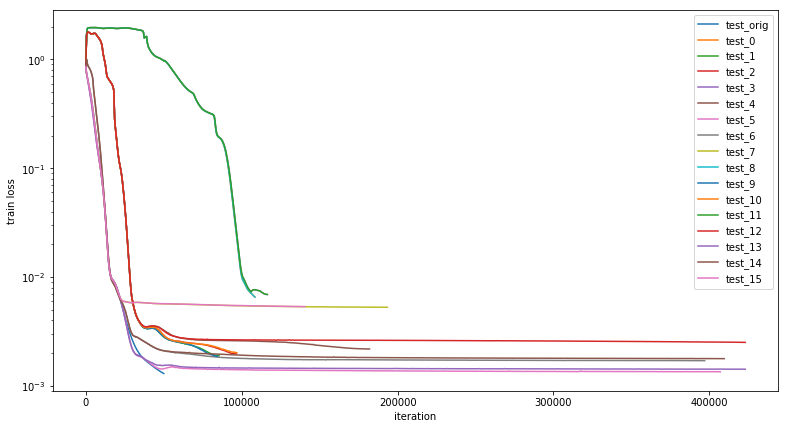

In [253]:
train_range = range(10, 21, 4)
n_runs = 2
dim = 2

configs = [
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.01,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1.02,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.05,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.0001,
     'constraint_sq_weight_multiplier': 1.1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 0.001,
     'constraint_sq_weight_multiplier': 1.1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 100},
    {'constraint_sq_weight': 1e-5,
     'constraint_sq_weight_multiplier': 2,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': None,
     'iterations': 20},
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.01,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.1,
     'constraint_sq_weight_multiplier': 1.02,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.01,
     'constraint_sq_weight_multiplier': 1.05,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.0001,
     'constraint_sq_weight_multiplier': 1.1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 0.001,
     'constraint_sq_weight_multiplier': 1.1,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 100},
    {'constraint_sq_weight': 1e-5,
     'constraint_sq_weight_multiplier': 2,
     'eps_gam_decay_rate': 0.98,
     'grad_threshold': 1e-3,
     'iterations': 20},
]
paths = []
labels = []
n_train = 18
train_seed = 1683
norm_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0, n_train, train_seed)
for i in range(len(configs)):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_aug_lag_auto_norm/'
    checkpoint_dir += 'dim-{}_config-{}_ntrain-{}_seed-{}/'.format(dim, i, n_train, train_seed)
    paths.append(checkpoint_dir + 'best.pkl')
    labels.append(str(i))

plot_train_loss2(dim, [norm_path]+paths, labels=['orig']+labels, includeTest=True)


# Other models

## Detweight model2

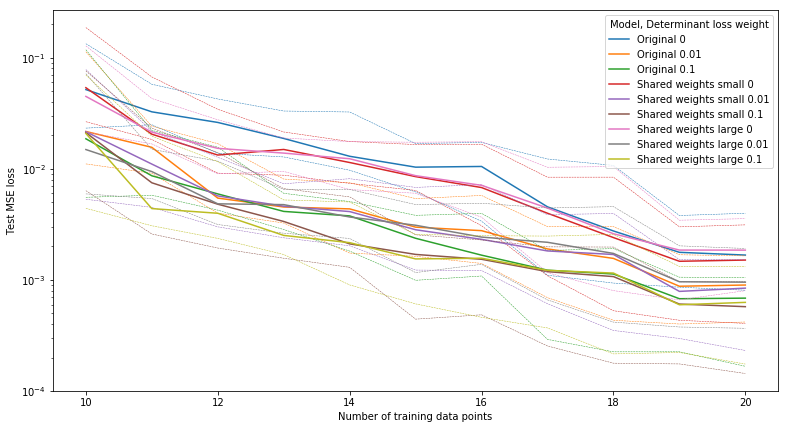

In [126]:
dim = 2
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight3/' if key[0] == 0 else ('round2_detweight_model2_orig/' if key[0] == 1 else 'round2_detweight_model2/')
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key[1], n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
train_range = range(10, 21, 1)
keys = [(a, b) for a in [0, 1, 2] for b in [0, 1e-2, 1e-1]]
n_runs = 10
stat_range = range(1683, 1683 + n_runs, 1)
names = ["Original", "Shared weights small", "Shared weights large"]
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key: Net if key[0] == 0 else (NetConnected if key[0] == 1 else NetConnected100), label=lambda key: names[key[0]] + " " + str(key[1]), legendTitle="Model, Determinant loss weight", filename="model2_pnlty")


## Normweight model2

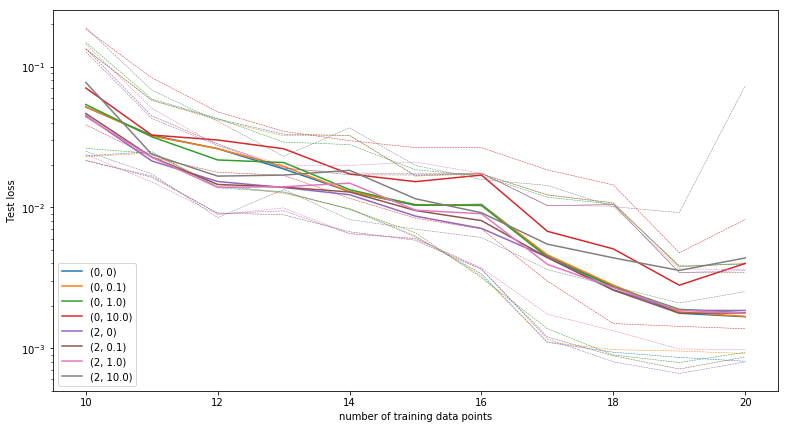

In [23]:
dim = 2
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight2/' if key[0] == 0 else ('round2_normweight_model2_orig/' if key[0] == 1 else 'round2_normweight_model2/')
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, key[1], n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
train_range = range(10, 21, 1)
keys = [(a, b) for a in [0, 2] for b in [0, 1e-1, 1e0, 1e1]]
n_runs = 10
stat_range = range(1683, 1683 + n_runs, 1)
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key: Net if key[0] == 0 else (NetConnected if key[0] == 1 else NetConnected100))

## Augmented lagrangian model2

In [129]:
def get_path(key, n_train, stat_val):
    if key[1] == "aug_lag":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det' + ('' if key[0] == 0 else '_model2') + '/'
        checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
            config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
            config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key[1] == "aug_lag_fixed":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_fixed' + ('' if key[0] == 0 else '_model2') + '/'
        checkpoint_dir += 'config_0/'
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key[1] == "det":
        if key[0] == 0:
            checkpoint_dir = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0.1, n_train, stat_val)
        else:
            checkpoint_dir = 'checkpoints/round2_detweight_model2_orig/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0.1, n_train, stat_val)
    else:
        if key[0] == 0:
            checkpoint_dir = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0, n_train, stat_val)
        else:
            checkpoint_dir = 'checkpoints/round2_detweight_model2_orig/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
dim = 2
train_range = range(10, 21, 1)
keys = [(a, b) for a in [0, 1] for b in ["orig", "det", "aug_lag", "aug_lag_fixed"]]
n_runs = 10
stat_range = range(1683, 1683 + n_runs, 1)
config = {'constraint_sq_weight': 0.001,
          'constraint_sq_weight_multiplier': 1.05,
          'eps': 1e-3,
          'gam': 0.1,
          'eps_gam_decay_rate': 0.95,
          'grad_threshold': None,
          'iterations': 50}

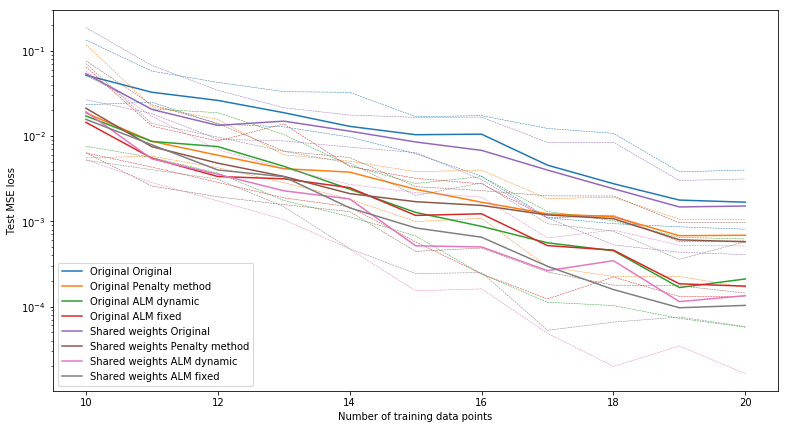

In [131]:
method_names = {'orig': "Original",
               'det': "Penalty method",
               'aug_lag': "ALM dynamic",
               'aug_lag_fixed': "ALM fixed"}
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key: Net if key[0] == 0 else NetConnected,
                          label=lambda key: ["Original", "Shared weights"][key[0]] + " " + method_names[key[1]])

## Normweight model3

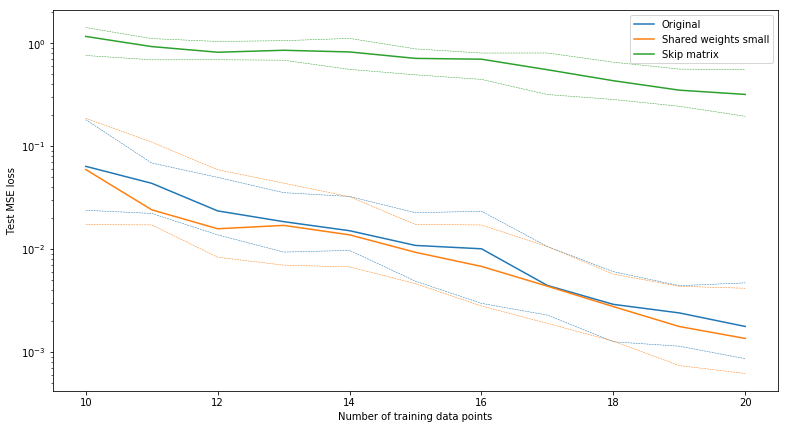

In [139]:
dim = 2
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight2/' if key == 0 else ('round2_normweight_model2_orig/' if key == 1 else 'round2_normweight_model3_2/')
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, 0, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
train_range = range(10, 21, 1)
keys = [a for a in [0, 1, 2]]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
model_names = ["Original", "Shared weights small", "Skip matrix"]
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key: Net if key == 0 else (NetConnected if key == 1 else NetNomatrix), label=lambda key: model_names[key], filename="model_comparison")

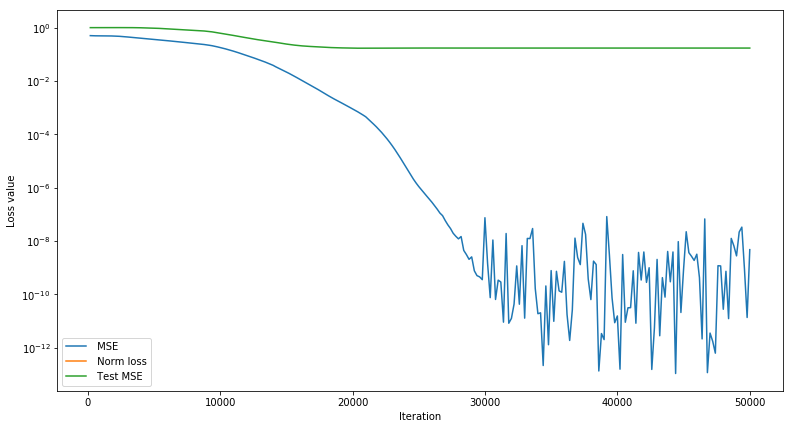

In [136]:
plot_train_loss(dim, ['checkpoints/round2_normweight_model3_3/dim-2_normweight-0_ntrain-20_seed-1683/final.pkl'], model_class=NetNomatrix16, includeTest=True)

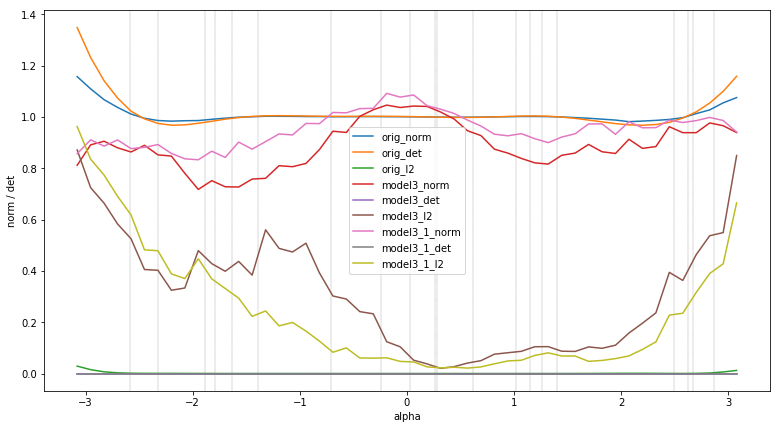

In [69]:
dim = 2
n_train = 20
train_seed = 1686
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
test_loader = get_data_loader(dim, 4096, seed=0, shuffle=False, batch_size=512)
# solver.fn_pred = fn_pred_normed

plt.figure(figsize=(13,7))
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
paths = []
labels = []
for key in ["orig", "model3", "model3_1"]:
    model = Net(dim) if key == "orig" else NetNomatrix16(dim)
    solver = Solver(model, is_matrix_model=key=="orig")
    path = 'checkpoints/round2_normweight2/dim-{}_normweight-0.1_ntrain-{}_seed-{}/final.pkl'.format(dim, n_train, train_seed)
    if key == "model3":
        path = 'checkpoints/round2_normweight_model3_3/dim-{}_normweight-0_ntrain-{}_seed-{}/final.pkl'.format(dim, n_train, train_seed)
    elif key == "model3_1":
        path = 'checkpoints/round2_normweight_model3_3/dim-{}_normweight-1.0_ntrain-{}_seed-{}/final.pkl'.format(dim, n_train, train_seed)
    paths.append(path)
    solver.load_checkpoint(path)
    angles, buckets = get_angles_stats_buckets(test_loader, train_loader, solver)
    plt.plot(angles, [np.array(b[1]).mean() for b in buckets], label=str(key)+'_'+'norm')
    plt.plot(angles, [np.array(b[2]).mean() for b in buckets], label=str(key)+'_'+'det')
    plt.plot(angles, [np.array(b[3]).mean() for b in buckets], label=str(key)+'_'+'l2')
    labels.append(str(key))
plt.ylabel("norm / det")
plt.xlabel("alpha")
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

## Plot matrix entries

In [147]:
def plot_matrix_nets(models, train_loader, labels=None, filename=None):
    if labels is None:
        labels = list(range(len(models)))
    test = np.linspace(-math.pi, math.pi, 100)
    fig, ax = plt.subplots(2, 2, figsize=(13, 7))
    matrices = [model(torch.Tensor(np.matrix(test).transpose())).detach().numpy() for model in models]
    ax[0, 0].plot(test, np.cos(test), label="cos")
    ax[0, 1].plot(test, -np.sin(test), label="-sin")
    ax[1, 0].plot(test, np.sin(test), label="sin")
    ax[1, 1].plot(test, np.cos(test), label="cos")
    for i in range(2):
        for j in range(2):
            for (_, angles, _) in train_loader:
                for angle in angles:
                    ax[i, j].axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
            for matrix, label in zip(matrices, labels):
                ax[i, j].plot(test, matrix[:, i, j], label=label)
            ax[i, j].legend(loc='best')
    plt.show()
    if filename is not None:
        fig.savefig("figs/" + filename + ".svg", format="svg")

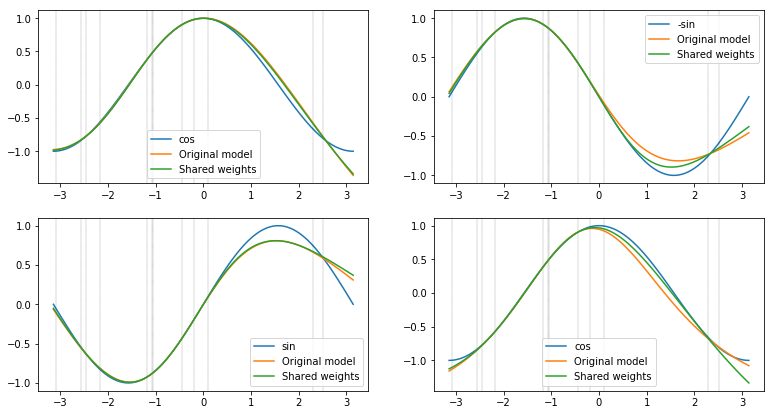

In [148]:
dim = 2
n_train = 12
train_seed = 1683
models = [Net(dim), NetConnected(dim)]
solvers = [Solver(model) for model in models]
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
solvers[0].load_checkpoint('checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, 0, n_train, train_seed))
solvers[1].load_checkpoint('checkpoints/round2_detweight_model2_orig/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, 0, n_train, train_seed))
plot_matrix_nets([solver.model for solver in solvers], train_loader, labels=["Original model", "Shared weights"], filename="model_matrix_entries")
